In [1]:
import os
import ee
import geemap

In [2]:
Map = geemap.Map() 
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [15]:
Map = geemap.Map(center=(-22.5, -54.5), zoom=6, lite_mode=False) 
Map

Map(center=[-22.5, -54.5], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(va…

In [16]:
ee.Initialize()

In [20]:
image = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate('2020-02-01', '2020-03-30') \
    .map(lambda img: img.divide(10000)) \
    .median()

vis_params = [
    {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'gamma': 1.3}, 
    {'bands': ['B8', 'B11', 'B4'], 'min': 0, 'max': 0.3, 'gamma': 1.3},
    {'bands': ['B8', 'B4', 'B3'], 'min': 0, 'max': 0.3, 'gamma': 1.3},
    {'bands': ['B12', 'B12', 'B4'], 'min': 0, 'max': 0.3, 'gamma': 1.3}
]

labels = [
    'Natural Color (B4/B3/B2)',
    'Land/Water (B8/B11/B4)',
    'Color Infrared (B8/B4/B3)',
    'Vegetation (B12/B11/B4)'
]

geemap.linked_maps(rows=2, cols=2, height="400px", center=[-20.4489,-54.6295], zoom=12, 
                   ee_objects=[image], vis_params=vis_params, labels=labels, label_position="topright")

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [21]:
Map = geemap.Map()

point = ee.Geometry.Point([-54.6295, -20.4489])
point2 = ee.Geometry.Point([-97, 35])

image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2016-01-01', '2016-12-31') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('B[1-7]')

image2 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point2) \
    .filterDate('2016-01-01', '2016-12-31') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('B[1-7]')

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}

Map.centerObject(point, 8)
Map.addLayer(image, vis_params, "Landsat-8")
Map.addLayer(image2, vis_params, "Landsat-8_2")

Map

Map(center=[-20.4489, -54.6295], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleBut…

In [22]:
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(image2.geometry())
Map.addLayer(nlcd, {}, 'NLCD')
Map

Map(bottom=36872.0, center=[-20.4489, -54.6295], controls=(WidgetControl(options=['position'], widget=HBox(chi…

In [23]:
# Make the training dataset.
points = nlcd.sample(**{
    'region': image2.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map.addLayer(points, {}, 'training', False)

In [24]:
# Use these bands for prediction.
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']


# This property of the table stores the land cover labels.
label = 'landcover'

# Overlay the points on the imagery to get training.
training = image2.select(bands).sampleRegions(**{
  'collection': points,
  'properties': [label],
  'scale': 30
})

# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

In [25]:
# Classify the image with the same bands used for training.
result = image.select(bands).classify(trained)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'classfied')
Map

Map(bottom=52344.0, center=[34.71452466170395, -96.61788940429688], controls=(WidgetControl(options=['position…

In [27]:
class_values = nlcd.get('landcover_class_values').getInfo()
class_palette = nlcd.get('landcover_class_palette').getInfo()
landcover = result.set('classification_class_values', class_values)
landcover = landcover.set('classification_class_palette', class_palette)

In [28]:
Map.addLayer(landcover, {}, 'Land cover')
Map.add_legend(builtin_legend='NLCD')
Map

Map(bottom=18531.0, center=[-19.880391767822505, -54.6734619140625], controls=(WidgetControl(options=['positio…

In [29]:
out_dir = os.path.expanduser('~/Downloads')
out_file = os.path.join(out_dir, 'landcover.tif')

In [30]:
geemap.ee_export_image(landcover, filename=out_file, scale=90)

Generating URL ...
Please wait ...
Data downloaded to /home/joseacm/Downloads/landcover.tif


In [31]:
Map = geemap.Map()

#-54.6295, -20.4489
#-54, -20

lon = -55
lat = -20
start_year = 1984
end_year = 2000

point = ee.Geometry.Point(lon, lat)
years = ee.List.sequence(start_year, end_year)

def get_best_image(year):   

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
        .filterBounds(point) \
        .filterDate(start_date, end_date) \
        .sort("CLOUD_COVER") \
        .median()    
    return ee.Image(image)

collection = ee.ImageCollection(years.map(get_best_image))


vis_params = {
  "bands": ['B4','B3','B2'],
  "min": 0,
  "max": 3000,
  }

image = ee.Image(collection.first())
Map.addLayer(image, vis_params, 'First image')
Map.setCenter(lon, lat, 13)
Map

Map(center=[-20, -55], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [32]:
import matplotlib.pyplot as plt
from geemap import cartoee

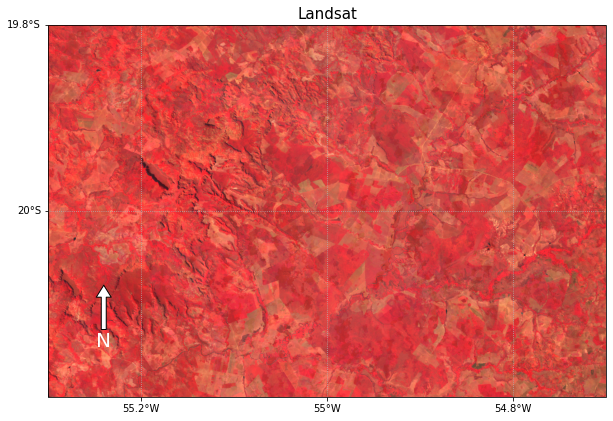

In [33]:
w = 0.3
h = 0.2

region = [lon-w, lat-h, lon+w, lat+h]

fig = plt.figure(figsize=(10, 8))

# use cartoee to get a map
ax = cartoee.get_map(image, region=region, vis_params=vis_params)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.2, 0.2], linestyle=":")

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.15,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center"
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# add scale bar
scale_bar_dict = {    "length": 10,     "xy": (0.1, 0.05),     "linewidth": 3,    "fontsize": 20,    "color": "white",    "unit": "km",    "ha": "center",    "va": "bottom"   }
#cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

ax.set_title(label = 'Landsat', fontsize=15)

plt.show()